# Attractors, stability, continuation

Introductory text: why you want to find attractors and why you want to undesratnd their stability

# Traditional continuation (automatic bifurcation analysis)

I have not yet decided whether to include this for educational purposes or not. Our Attractors.jl framework is so much more powerful than the traditional continuation stuff, that I feel like as a practicioner 99% of the time I would be using only Attractors.jl. Therefore, is it even worth teaching in this course that has a practice-oriented focus?

If yes, then this section would introduce BifurcationKit.jl.

# Attractors.jl

A Julia module for finding attractors of dynamical systems,
their basins and their boundaries, fractal properties of the boundaries,
as well as continuing attractors and their basins across parameters.

In [3]:
import Pkg
Pkg.activate(dirname(@__DIR__))
Pkg.status(["DynamicalSystems", "Attractors", "CairoMakie", "OrdinaryDiffEq"]; mode = Pkg.PKGMODE_MANIFEST)

Status `C:\Users\gd419\OneDrive - University of Exeter\Teaching\NonlinearDynamicsComplexSystemsCourses\Manifest.toml`
  [f3fd9213] Attractors v1.9.1
  [13f3f980] CairoMakie v0.10.8
  [61744808] DynamicalSystems v3.2.0
  [1dea7af3] OrdinaryDiffEq v6.55.0


  Activating project at `c:\Users\gd419\OneDrive - University of Exeter\Teaching\NonlinearDynamicsComplexSystemsCourses`


## Finding attractors and their basins fractions

The bulk of the work in Attractors.jl is done by subtypes of `AttractorMapper`. Each subtype encapsulates an algorithm that allows to map initial conditions into attractors. The concrete subtypes that we'll cover here are:

1. `AttractorsViaRecurrences` 
2. `AttractorsViaFeaturizing`

Let's start with the recurrences version. It implements the algorithm described in [Datseris & Wagemakers (2022), _Effortless estimation of basins of attraction_](https://doi.org/10.1063/5.0076568). Understanding of the algorithm is useful for deciding the keyword arguments of `AttractorsViaRecurrences`, however, explaining this algorithm in detail is not a part of this lecture due to time constraints! Worry not however, the exercises have been designed to work well with the default keywords!

The very short description is that, for "simple" dynamical systems like `CoupledODEs` or `DeterministicIteratedMap`, the Poincare recurrence theorem applies: it says that as the system state evolves on an attractor, it is guaranteed to visit a state space region it has already visited before. This is called a **recurence**. The `AttractorsViaRecurrences` utilizes this fact to find attractors by tesselating a finite region of the state space into finite-sized cells.

**FIGURE HERE EXPLAINING!**

The only thing you need to know about the algorithm is the following: it uses recurrences in the state space to find the **actual** attractors of a dynamical system. This is done  Therefore, to initialize an `AttractorsViaRecurrences` we need two things:

1. A dynamical system instance
2. A grid that both decides the state space region of interest as well as defines its tesselation

We'll use this mapper to find attractors of the following dynamical system:
$$
\begin{aligned}
\dot{x} &= \sin(y) - bx\\
\dot{y} &= \sin(z) - by\\
\dot{z} &= \sin(x) - bz
\end{aligned}
$$
which is also called ["Thomas' cyclical system"](https://en.wikipedia.org/wiki/Thomas%27_cyclically_symmetric_attractor). Due to the symmetry of the equations of motion, any attractor has three symmetry versions (by cycling over the x, y, z coordinates). So this is a multistable dynamical system! 

For `b = 0.16` the system has three (symmetric) attracting limit cycles that can be found in the state space box spaning -3 to 3 in each dimension (we know this a-priori for this example).

Let's define the dynamical system:

In [2]:
using DynamicalSystems

function thomas_rule(u, p, t)
    x,y,z = u
    b = p[1]
    xdot = sin(y) - b*x
    ydot = sin(z) - b*y
    zdot = sin(x) - b*z
    return SVector(xdot, ydot, zdot)
end

thomas = CoupledODEs(thomas_rule, ones(3), [0.16])

3-dimensional CoupledODEs
 deterministic: true
 discrete time: false
 in-place:      false
 dynamic rule:  thomas_rule
 ODE solver:    Tsit5
 ODE kwargs:    (abstol = 1.0e-6, reltol = 1.0e-6)
 parameters:    [0.16]
 time:          0.0
 state:         [1.0, 1.0, 1.0]


Next, we need to define the state space grid. This is as easy as defining a range for each of the dimensions and putting them in a tuple:

In [3]:
xg = yg = zg = range(-6.0, 6.0; length = 101)

grid = (xg, yg, zg)

(-6.0:0.12:6.0, -6.0:0.12:6.0, -6.0:0.12:6.0)

Now we use these two pieces of information to initialize the `AttractorMapper` we want:

In [4]:
mapper = AttractorsViaRecurrences(thomas, grid)

AttractorsViaRecurrences
 rule f:      AttractorsViaRecurrences
 system:      CoupledODEs
 grid:        (-6.0:0.12:6.0, -6.0:0.12:6.0, -6.0:0.12:6.0)
 attractors:  Dict{Int32, StateSpaceSet{3, Float64}}()


The main job of a mapper is to tell you to which attractor an initial condition `u0` converges to via the syntax `mapper(u0)`. For example,

In [11]:
mapper([0.5, 2.0, 1.0])

1

In [12]:
mapper([0.5, 2.0, -1.0])

2

In [13]:
mapper([0.5, 2.5, -1.0])

1

Attractors are labelled with the positive integers.

With this mapper we could now compute the **basins of attraction** of `thomas` by evolving an initial condition for each point in the state space and coloring it according to the attractor it converges to.  However, this is computationally tractable only for very low dimensional dynamical systems.

Therefore, the main way to use an `AttractorMapper` is with the `basins_fractions` function. You give it the mapper, and some initial conditions, and `basins_fractions` will map these initial conditions to attractors, collect their labels (i.e., which attractor they end up to), and return the fractions of basins of attraction.

Let's create a function that generates initial conditions on the fly using the existing `statespace_sampler` library function

In [15]:
sampler, = statespace_sampler(
    # provide random samples within the minimum and maximum limits
    min_bounds = minimum.(grid), max_bounds = maximum.(grid)
)
sampler()

3-element Vector{Float64}:
 -4.561107565676815
 -3.1969466653021428
 -5.040775859519997

In [16]:
sampler()

3-element Vector{Float64}:
 -4.814854390621194
 -2.583508153048487
  4.047635252285827

Then we give the mapper and the sampler to `basins_fractions`:

In [20]:
@time fractions = basins_fractions(
    mapper, sampler; 
    show_progress = false, 
    N = 100_000, # how many random samples to use
)
fractions

  4.059647 seconds (1.30 M allocations: 164.719 MiB, 0.96% gc time)


Dict{Int64, Float64} with 3 entries:
  2 => 0.33361
  3 => 0.33354
  1 => 0.33285

As you can see, the function collected all unique attractor labels and created a dictionary mapping the labels to the fractions of initial conditions that went to the given attractor. This is called the state space fraction of the basins of attraction, or **the basins fractions** for sort.

We can extract the attractors as a dictionary mapping the labels to attractors (`StateSpaceSet`s)

In [ ]:
attractors = extract_attractors(mapper)

Dict{Int32, StateSpaceSet{3, Float64}} with 3 entries:
  2 => 3-dimensional StateSpaceSet{Float64} with 240 points
  3 => 3-dimensional StateSpaceSet{Float64} with 240 points
  1 => 3-dimensional StateSpaceSet{Float64} with 240 points

Let's visualize the attractors found!

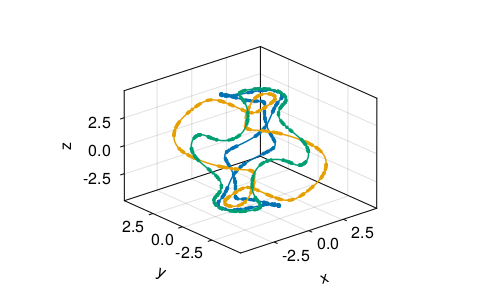

In [ ]:
fig = Figure()
ax = Axis3(fig[1,1])
for (k, A) in attractors
    # Scatter the sample points on the attractor
    scatter!(ax, vec(A); markersize = 5)
    # Also evolve an i.c. on the attractor and line plot it
    X, t = trajectory(thomas, 50.0, A[1])
    xt, yt, zt = columns(X)
    lines!(ax, xt, yt, zt)
end
fig

## `AttractorsViaFeaturizing`

This is an alternative way to find "attractors", which works as follows:
1. Initial conditions are evolved to generate trajectories
2. Trajectories are mapped into "features": descriptive numbers of the trajectories that hopefully characterize different attractors differently. E.g., mean and std. of the first two  variables for a four-dimensional feature.
3. Features are grouped with one of the three following ways:
   1. `GroupViaClustering`
   2. `GroupViaNearestFeature`
   3. `GroupViaHistogram`
4. The generated groups then correspond to unique "attractors".



It is not obvious what features would be good to separate the attractors of the previous example, which is why we recommend the recurrences method as the better method to use in those kinds of systems.

In any case, here we have estimated in advance a featurizer that works well:

In [ ]:
using Statistics: mean, std

function featurizer(A, t) # take in trajectory and time vector
    x, y, z = columns(A)
    mx = mean(x)
    sx = std(y)
    cz = std(y .- z)
    return SVector(mx, sx, cz) # return feature, preferably as static vector
end

grouping_config = GroupViaClustering()

We also choose how to group features together. For simplicitly, we will use a black box clustering algorithm

In [ ]:
grouping_config = GroupViaClustering();

We now put everything together in `AttractorsViaFeaturizin` and get the fractions of the basins of attraction:

In [ ]:
mapperf = AttractorsViaFeaturizing(
    thomas, featurizer, grouping_config; 
    Ttr = 100.0, T = 50.0, Δt = 0.1
)

fs = basins_fractions(
    mapperf, sampler; 
    show_progress = false
)

# Exercises - Attractors.jl

## Basins of attraction of a multistable predator prey model

Consider the following (modified) form of the Rozenweig-MacArthur continuous time model for predator-prey dynamics:
$$

\begin{align}
\frac{dN}{dt} & = rN\left(1-\frac{c}{r}N\right)\left(\frac{N-\mu}{N+\nu}\right) - A \\
\frac{dP}{dt} & = \chi A - \delta P \\
A & = \frac{\alpha N P}{\beta + N} 
\end{align}
$$

with initial parameters `p = [1.7, 0.19, 0.03, 0.003, 800, 1.5, 0.004, 2.2] = r, c, μ, ν, α, β, χ, δ`.


Consider the following two parameter values: `r1 = 1, r2 = 2`. For each parameter value, use the `AttractorViaRecurrences` and `basins_of_attraction` to compute, and plot, the basins of attraction. On top of the basins of attraction also scatterplot the returned attractors. 

For this exercise, use the following grid:

```julia
density = 201
xg = range(0, 20; length = density)
yg = range(0, 0.03; length = density)
grid = (xg, yg)
```

and use the following keywords for the `AttractorsViaRecurrences`:
```julia
kwargs = (
    mx_chk_fnd_att = 2000, mx_chk_loc_att = 4000,
    force_non_adaptive = true, Δt = 0.05,
)
```

_Hint: this forces the ODE integrator to use a non-adaptive step control. This is useful in some systems with limit cycles, because there an adaptive solver makes the solver step size commensurate with the limit cycle period, which leads to incorrect assignment of initial conditions to the limit cycle._

The exercise solution is a plot that looks like the one below:

_Hint: If `A` is a `StateSpaceSet` (i.e., an attractor), then you can do `scatter!(ax, (vec(A))` to immediatelly scatterplot the attractor into an axis!_

![makie_ex_fig_1.png](basins_ex_fig_1.png)

## Continuation of attractors and their basins fractions

_Note: here we are talking about continuation of arbitrary attractors and their basins of attraction. This is NOT the traditional linearized bifurcation analysis and continuation of fixed points. To learn more about the differences, read our [comparison section online](https://juliadynamics.github.io/Attractors.jl/dev/continuation/#A-new-kind-of-continuation)!_

Continuation in the context of Attractors.jl is done using the `continuation` function, so let's read its documentation string:

In [ ]:
@doc continuation

Alright, let's now focus on one of two continuation methods, the Recurrences Find and Match (RAFM). Applying this method to the cyclical Thomas system we analyzed in the previous section is not interesting, because due to symmetry the basins fractions are constantly 1/3 each. Instead, let's try to find, and continue, the attractors and the basins of attraction of the model from:

> Synthetic multistability in mammalian cells, Zhu et al., Science 375 (2022), DOI: 10.1126/science.abg9765
>
> _An important goal for synthetic biology is to establish control systems that allow the direction of cells into multiple stable states, much like biological signaling systems do during organismal development. Zhu et al. devised a system that allows such control through designed zinc finger transcription factors that interact with one another through homo- and heterodimerization and can be regulated by small molecules that control dimerization and stability of the transcription factors (see the Perspective by Kunze and Khalil). Mathematical modeling allowed computational prediction of the system’s behavior, and introduction of three designed transcription factors in cultured mammalian cells allowed direction of the cells into seven distinct, stable states. Understanding such multistability is useful in synthetic biology and can help to determine its roles in development and disease processes._

 

$$
\dot{A_i} = \alpha + \beta \frac{ B_i^n }{ 1 + B_i^n } - A_i, \quad i = 1, \ldots, N, 
$$

with

$$
B_i = \frac{2A_i^2}{ K_d + 4\sum A_i  + \sqrt{ K_d^2 + 8\sum A_i + K_d } }
$$

Here we will use $N=3$, which makes a 3-dimensional continuous time system. The starting parameters will be `α=4, β=20, n=1.5, Kd=80.0`. We are interested in the behavior of the model versions the `Kd` parameter. 

For the recurrences algorithm we do not need much accuracy for this particular system. The state space tesselation will therefore be from 0 to 100 for each dimension, divided into 100 cells.

In [ ]:
# Define dynamical system
function cell_differentiation(N = 3, u0 = rand(N); α=4, β=20, n=1.5, Kd=80.0)
    p = [Kd, α, β, n]
    ds = CoupledODEs(cell_differentiation_rule!, u0, p)
    return ds
end
function cell_differentiation_rule!(du, u, p, t)
    Kd, α, β, n = p
    sum_u = sum(u)
    @inbounds for i ∈ eachindex(du)
        C = (2*u[i]^2) / (Kd + 4*sum_u + sqrt( Kd^2 + 8*sum_u*Kd )  )
        du[i] = α + (β*C^n)/(1+C^n) - u[i]
    end
    return nothing
end

ds = cell_differentiation(3)

Let's create an `AttractorsViaRecurrences`, and check how many attractors are there in the default values

In [ ]:
mapper_config = (;mx_chk_safety = Int(1e9))
grid = ntuple(i -> range(0, 100, length=101), 3)

sampler, = statespace_sampler(
    min_bounds = minimum.(grid), max_bounds = maximum.(grid)
)

mapper = AttractorsViaRecurrences(
    ds, grid; mapper_config...
)

fs = basins_fractions(mapper, sampler)
attractors = extract_attractors(mapper)

Great! Since we have the attractor mapper already, the only thing we need to do to continue these attractors accross a parameter range is to initialize a `RecurrencesFindAndMatch` instance with the `mapper`, and give it to the `continuation` function!

In [ ]:
rsc = RecurrencesFindAndMatch(mapper; threshold = Inf)

pidx = 1 # index of parameter to change (here Kd)
prange = range(0, 100; length = 101) # parameter range to scan

fractions_curves, attractors_info = continuation(
    rsc, prange, pidx, sampler;
    show_progress = false, samples_per_parameter = 100
)
fractions_curves

Let's now plot the results we found using one of the provided plotting functions from Attractors.jl:

In [ ]:
# Decide how to plot attractors: go from attractor to real number
attractor_to_real = A -> mean((x[1] + x[2])/2 for x in A)

plot_basins_attractors_curves(fractions_curves, attractors_info, attractor_to_real, prange)

## Exercises - continuation of basins fractions

Continue from the previous exercise, and now use the `continuation` function to continue attractors and their fractions across the parameter range `r = 1` to `2`. Use the `statespace_sampler` function to generate random initial conditions in the `grid` you defined above. Plot the fractions of basins of attraction versus the parameter range, and the attractor value, using the following function to map attractors to real numbers:
```julia
using Statistics: mean
attractor_to_real = A -> mean((x[1] + x[2])/2 for x in A)
```

The solution of the exercise should be that you have only two attractors and the fractions of their basins are approximately 50% all the time.

This is weird, right? Focus on `r = 1`. In this case, in the first exercise, you found three attractors, all three being fixed points. Can you give a reasonable explanation of this discrepency, and why the third attractor was not found in the continuation case...?

_hint: think of what kind of initial conditions are generated by the random sampling process, or by scanning the grid explicitly_